In [1]:
import numpy as np
import pandas as pd
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

from tifffile import TiffFile

Load Images

In [11]:
%%time
tif_paths = [
    'data/VIIRS/F101992.v4/F101992.v4b_web.stable_lights.avg_vis.tif',
    'data/VIIRS/F101993.v4/F101993.v4b_web.stable_lights.avg_vis.tif',
    'data/VIIRS/F101994.v4/F101994.v4b_web.stable_lights.avg_vis.tif',
    'data/VIIRS/F121994.v4/F121994.v4b_web.stable_lights.avg_vis.tif',
    'data/VIIRS/F121995.v4/F121995.v4b_web.stable_lights.avg_vis.tif',
    'data/VIIRS/F121996.v4/F121996.v4b_web.stable_lights.avg_vis.tif',
    'data/VIIRS/F182013.v4/F182013.v4c_web.stable_lights.avg_vis.tif'
]
t_years = len(tif_paths)
n = 3000
m = 3000

images = np.zeros((len(tif_paths),n,m))
                  
for i, p in enumerate(tif_paths):
    with TiffFile(p) as tif:
        images[i] = tif.asarray()[(coord[1]-d/2):(coord[1]+d/2),(coord[2]-d/2):(coord[2]+d/2)]

/Users/jpw/Development/ganter/ganv/lib/python3.5/site-packages/ipykernel/__main__.py:18: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


CPU times: user 2.55 s, sys: 14.1 s, total: 16.6 s
Wall time: 24.6 s


Load Data

In [12]:
# df_images = pd.read_csv('data/features.csv', index_col='i')


# df_images_1992 = df_images[df_images['year'] == 1992].sort('f')
# df_images_2013 = df_images[df_images['year'] == 2013].sort('f')
# df_images_2013['mean_luminosity_delta'] = (df_images_2013['mean_luminosity'].as_matrix() - df_images_1992['mean_luminosity'].as_matrix()) / df_images_1992['mean_luminosity'].as_matrix() 
# df_images = df_images_2013

df_quakes = pd.read_csv('data/interim/USGeoQuakes.csv', index_col=0)

Translate coordinate locations into image x- and y-Axes

In [23]:
df_quakes['viirs_x'] = df_quakes['viirs_y'] = np.nan
df_quakes = df_quakes.sort('mag',ascending=False)
df_quakes = df_quakes.apply(create_coordinate,axis=1)

/Users/jpw/Development/ganter/ganv/lib/python3.5/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


In [24]:
df_quakes[['viirs_x','viirs_y','latitude','longitude']].head(1)

,viirs_x,viirs_y,latitude,longitude
28763,1.127187e+06,3.962807e+06,3.295,95.982


In [16]:
images.shape

(7, 3000, 3000)

In [6]:
coord = next(df_quakes.sort('mag',ascending=False)[['viirs_x','viirs_y']].itertuples())
print(coord)
d=3000
plt.imshow(images[1,(coord[1]-d/2):(coord[1]+d/2),(coord[2]-d/2):(coord[2]+d/2)],cmap='spectral')
plt.show()

/Users/jpw/Development/ganter/ganv/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


Pandas(Index=28763, viirs_x=9395.9592499999999, viirs_y=33118.606616666664)


NameError: name 'images' is not defined

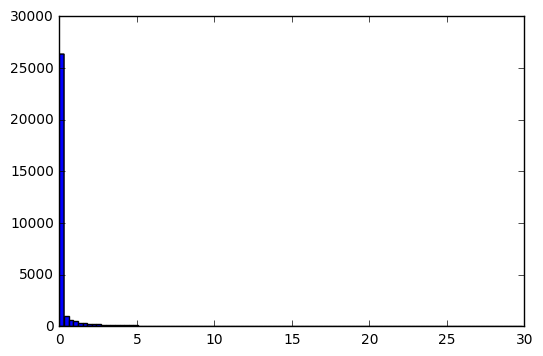

In [238]:
plt.hist(df_images['mean_luminosity'],bins=100)
# plt.hist(df_quakes['mag'],bins=10)
plt.show()

In [239]:
df_images = df_images[df_images['mean_luminosity'] > 10]
df_quakes = df_quakes[df_quakes['mag'] > 7]
print('These configurations make %i iterations.' % (df_images.shape[0] * df_quakes.shape[0]))

These configurations make 115920 iterations.


In [240]:
df_images['center_x'] = df_images['pxlb'] - (df_images['pxlb'] - df_images['pxlt']) / 2
df_images['center_y'] = df_images['pxll'] - (df_images['pxll'] - df_images['pxlr']) / 2

/Users/jpw/Development/ganter/ganv/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/jpw/Development/ganter/ganv/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [241]:
def calculate_disaster_coefficient(image):
    disco = 0
    for q in df_quakes[['viirs_x','viirs_y']].itertuples():
        disco = disco + abs(25 - np.sqrt(np.linalg.norm([
            image['center_x'] - q[1],
            image['center_y'] - q[2]
        ])))
        
    image['disco'] = disco / df_quakes.shape[0]
    return image

In [242]:
%%time
df_images['disco'] = np.nan
df_images = df_images.apply(calculate_disaster_coefficient,axis=1)
df_images.head()

/Users/jpw/Development/ganter/ganv/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


CPU times: user 5.02 s, sys: 79 ms, total: 5.1 s
Wall time: 5.33 s


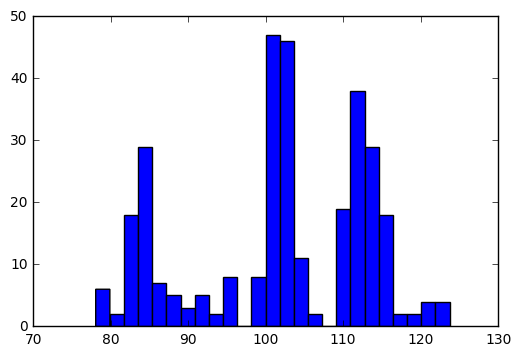

In [243]:
plt.hist(df_images['disco'],bins=25)
plt.show()

In [244]:
df_images['mean_luminosity_delta'].min()

-0.17992274252263604

In [245]:
df_images['mean_luminosity_delta'].max()

7.4366997439180533

In [250]:
from sklearn.preprocessing import normalize
df_images['disconorm'] = normalize(df_images['disco'])[0]

/Users/jpw/Development/ganter/ganv/lib/python3.5/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


In [263]:
df_images[['mean_luminosity_delta','disconorm']].head()

,mean_luminosity_delta,disconorm
i,,
3032 1,0.907221,0.056441
3033 1,0.696113,0.056353
3308 1,0.444145,0.057240
3309 1,0.466268,0.057154
3320 1,0.853406,0.056192


In [264]:
np.corrcoef(df_images['mean_luminosity_delta'],df_images['disconorm'])[0,1]

-0.49640806951093491

In [274]:
df_images['disconorm'].as_matrix().reshape((315,1)).shape

(315, 1)

In [289]:
from sklearn.linear_model import LinearRegression
regr = LinearRegression()
# Train the model using the training sets
regr.fit(df_images['mean_luminosity_delta'].as_matrix().reshape((315,1)),df_images['disconorm'].as_matrix())

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

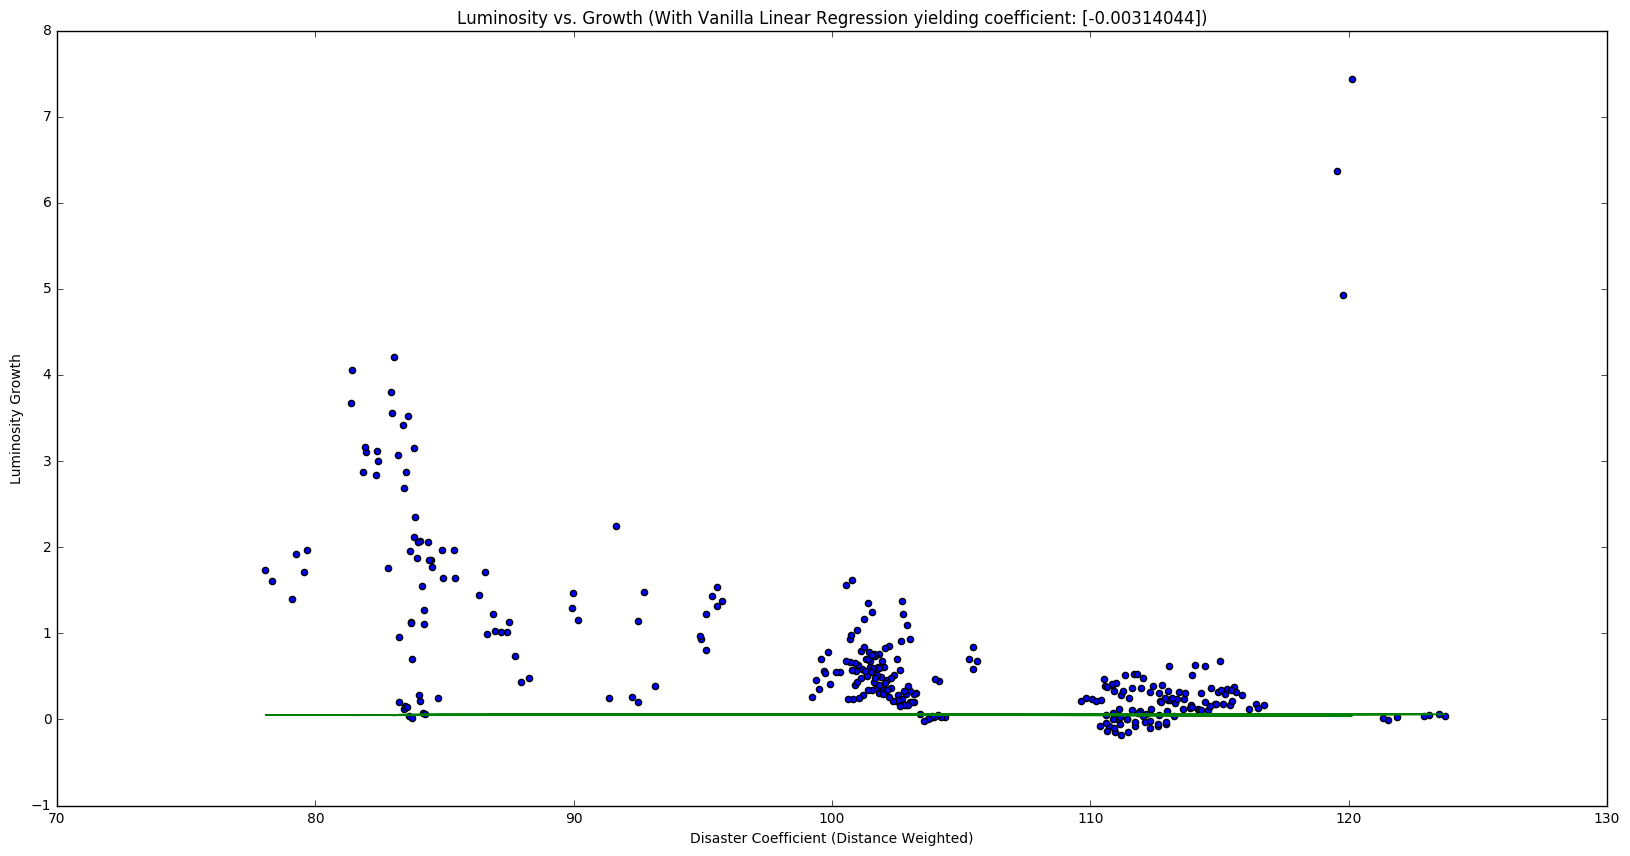

In [292]:
plt.figure(figsize=(20,10))
plt.scatter(df_images['disco'],df_images['mean_luminosity_delta'])
plt.plot(df_images['disco'], regr.predict(df_images['mean_luminosity_delta'].as_matrix().reshape((315,1))), color='green')
plt.xlabel('Disaster Coefficient (Distance Weighted)')
plt.ylabel('Luminosity Growth')
plt.title('Luminosity vs. Growth (With Vanilla Linear Regression yielding coefficient: ' + str(regr.coef_) + ')')
plt.show()